In [1]:
import pickle
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import shapiro

from typing import Dict, Optional

from matplotlib.axes import Axes
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_theme()
sns.set_context("talk")  # paper, notebook, talk, and poster

In [2]:
def shapiro_test(data):
    # calculate the statistics
    stat, p = shapiro(data)
    # interpret the p-value
    alpha = 0.05
    if p > alpha:
      print('Sample looks Gaussian (fail to reject H0)')
    else:
      print('Sample does not look Gaussian (reject H0)')
    return p


def hist(ax: Axes, data: torch.Tensor, label: str) -> None:
    """
    Plot a histogram of the data.

    Args:
        ax (matplotlib.axes.Axes): The axes to plot on.
        data (torch.Tensor): The data to plot.
        label (str): The label of the data.
    """

    sns.histplot(data, ax=ax, kde=True, stat="density")
    ax.set_xlabel(label)
    ax.set_ylabel("Density")
    # write the mean and std to the top center of image
    mean = data.mean()
    std = data.std()
    ax.text(
        0.5,
        0.95,
        f"Mean: {mean:.2f}, Std: {std:.2f}",
        horizontalalignment="center",
        transform=ax.transAxes,
    )


def compute_gap_statistics(
    features1: torch.Tensor,
    features2: torch.Tensor,
    title: str,
) -> Dict:
    """
    Compute the statistics of the modality gap between features from two different modalities.

    Args:
        features1 (torch.Tensor): Features from the first modality.
        features2 (torch.Tensor): Features from the second modality.
        title (str): The title of the plot.

    Returns:
        Dict: A dictionary containing the statistics of the modality gap.
    """

    assert (
        len(features1.shape) == 2 and len(features2.shape) == 2
    ), "Features should be 2D."

    features1, features2 = F.normalize(features1), F.normalize(features2)

    gaps = features1 - features2
    shuffled_idx = torch.randperm(gaps.shape[0])
    gaps = gaps[shuffled_idx]
    print(f"Previous shape: {gaps.shape}")
    group_size = 100
    gaps = gaps[: (gaps.shape[0] // group_size) * group_size]
    gaps = gaps.reshape(-1, group_size, gaps.shape[-1])
    gaps = gaps.mean(dim=1)
    print(f"New shape: {gaps.shape}")

    figsize = (30, 6)

    fig, ax = plt.subplots(1, 5, figsize=figsize)

    magnitudes = gaps.norm(dim=-1)
    hist(ax[0], magnitudes, "Gap Length")

    directions = F.cosine_similarity(gaps[1:], gaps[:-1])
    hist(ax[1], directions, "Gap Direction")

    orthogonalities = F.cosine_similarity(features1[1:] - features1[:-1], gaps.mean(dim=0, keepdim=True))
    hist(ax[2], orthogonalities, "Gap Orthogonality")

    gaps = features1 - features2
    shuffled_idx = torch.randperm(gaps.shape[0])
    gaps = gaps[shuffled_idx]

    residuals = gaps - gaps.mean(dim=0)

    residual_magnitudes = residuals.mean(0)
    hist(ax[3], residual_magnitudes, "Noise Mean")

    residual_directions = F.cosine_similarity(residuals[1:], residuals[:-1])
    hist(ax[4], residual_directions, "Noise Direction")

    fig.suptitle(title)
    plt.show()

    return {
        "magnitude": magnitudes,
        "direction": directions,
        "orthogonality": orthogonalities,
        "residual_magnitude": residual_magnitudes,
        "residual_direction": residual_directions,
    }

Previous shape: torch.Size([123287, 512])
New shape: torch.Size([1232, 512])


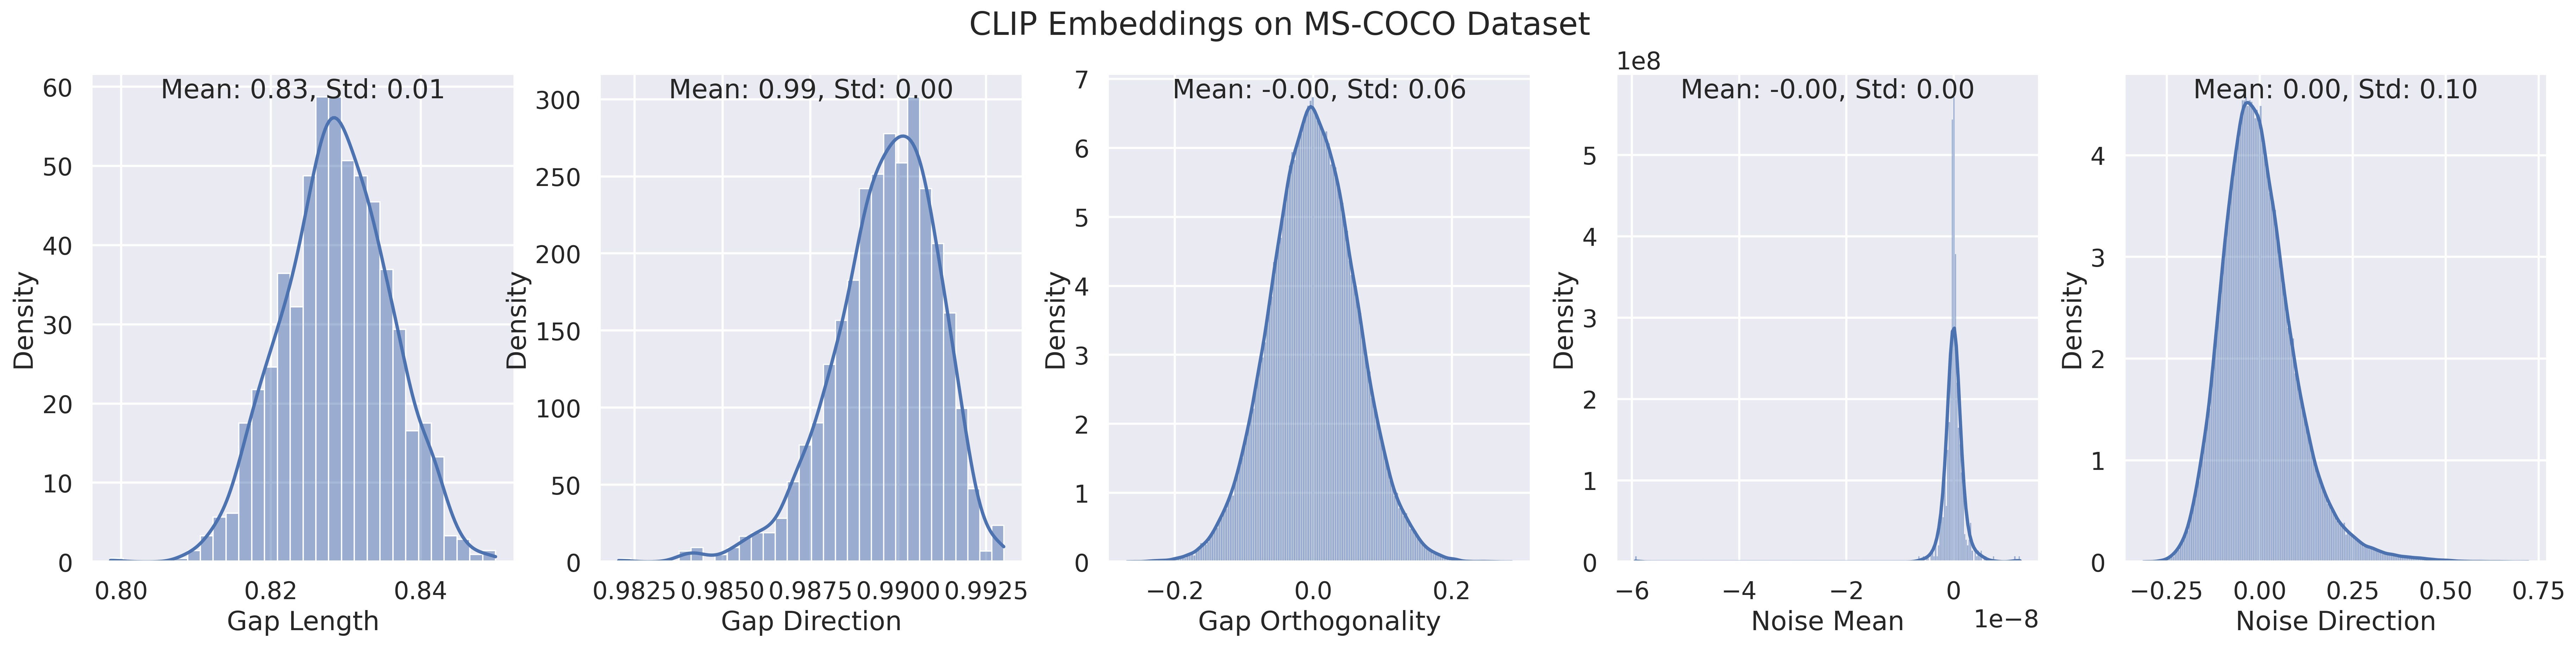

In [3]:
features = torch.load("features/coco_features_vitb32.pt")
_ = compute_gap_statistics(
    features["image_features"],
    features["text_features"],
    "CLIP Embeddings on MS-COCO Dataset",
)

/tmp/user/19662/ipykernel_3382988/4227699844.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  image_features = torch.tensor([item["x_embed"] for item in features])


Previous shape: torch.Size([616435, 1024])
New shape: torch.Size([6164, 1024])


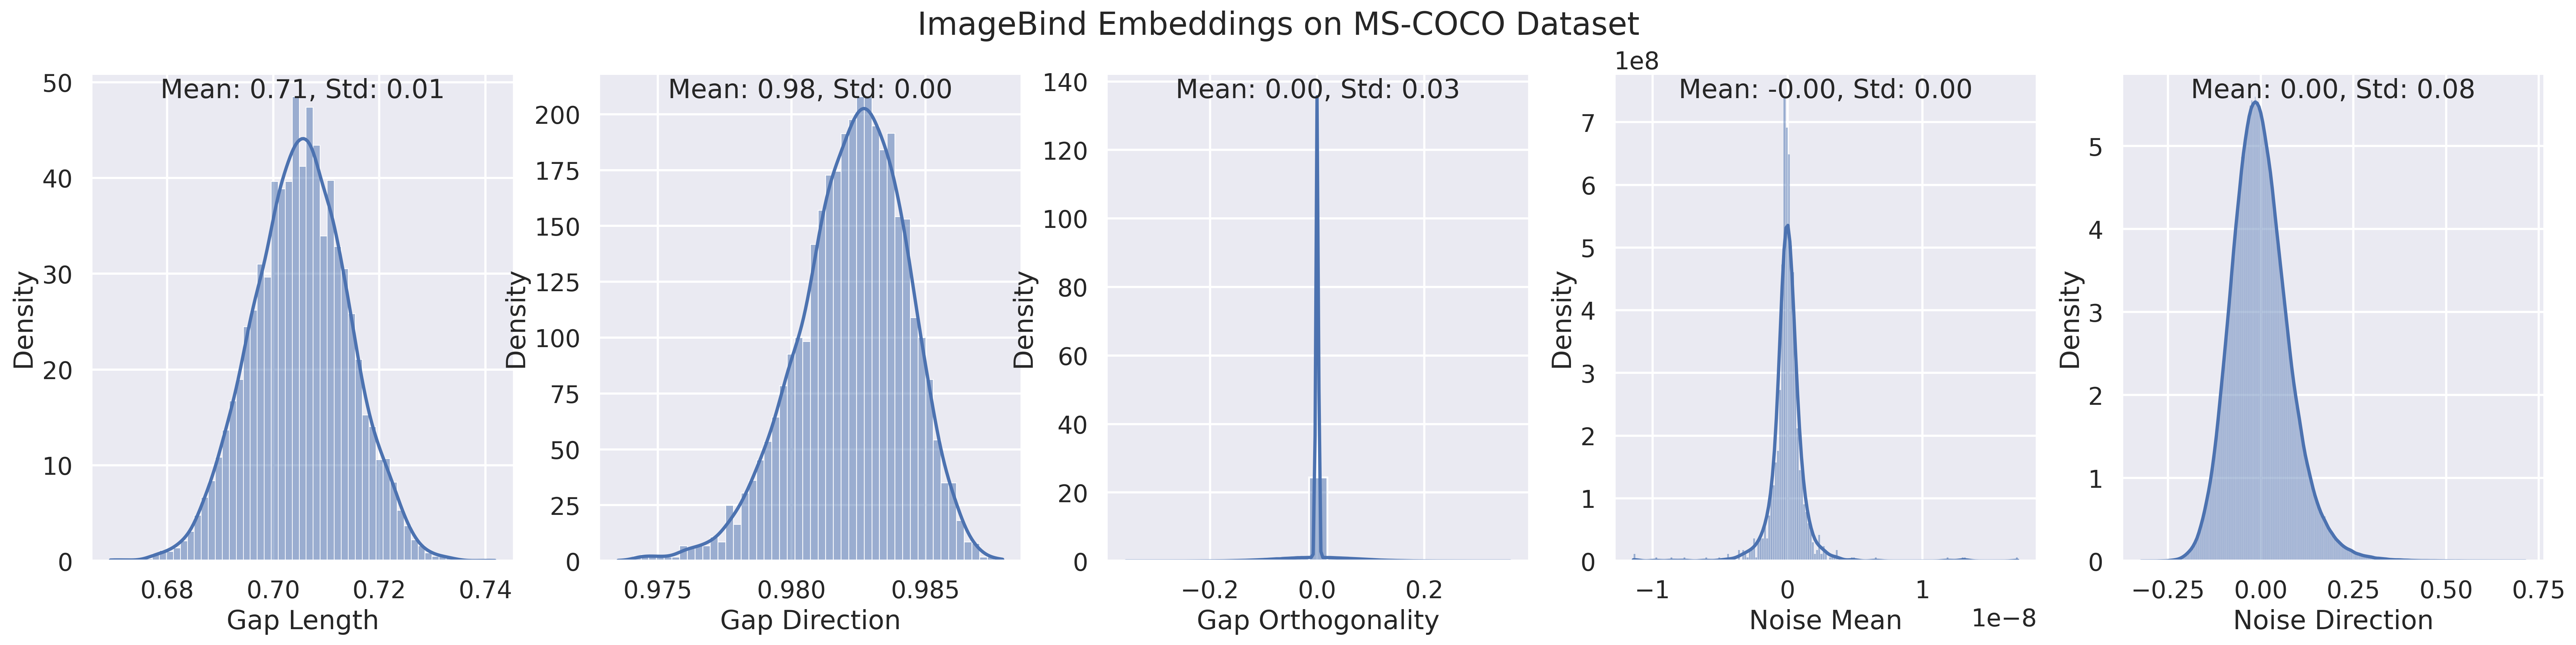

In [4]:
features = pickle.load(open("../data/data_image_coco_imagebind.pkl", "rb"))
image_features = torch.tensor([item["x_embed"] for item in features])
text_features = torch.tensor([item["y_embed"] for item in features])
_ = compute_gap_statistics(
    image_features,
    text_features,
    "ImageBind Embeddings on MS-COCO Dataset",
)

Previous shape: torch.Size([19690, 1024])
New shape: torch.Size([196, 1024])


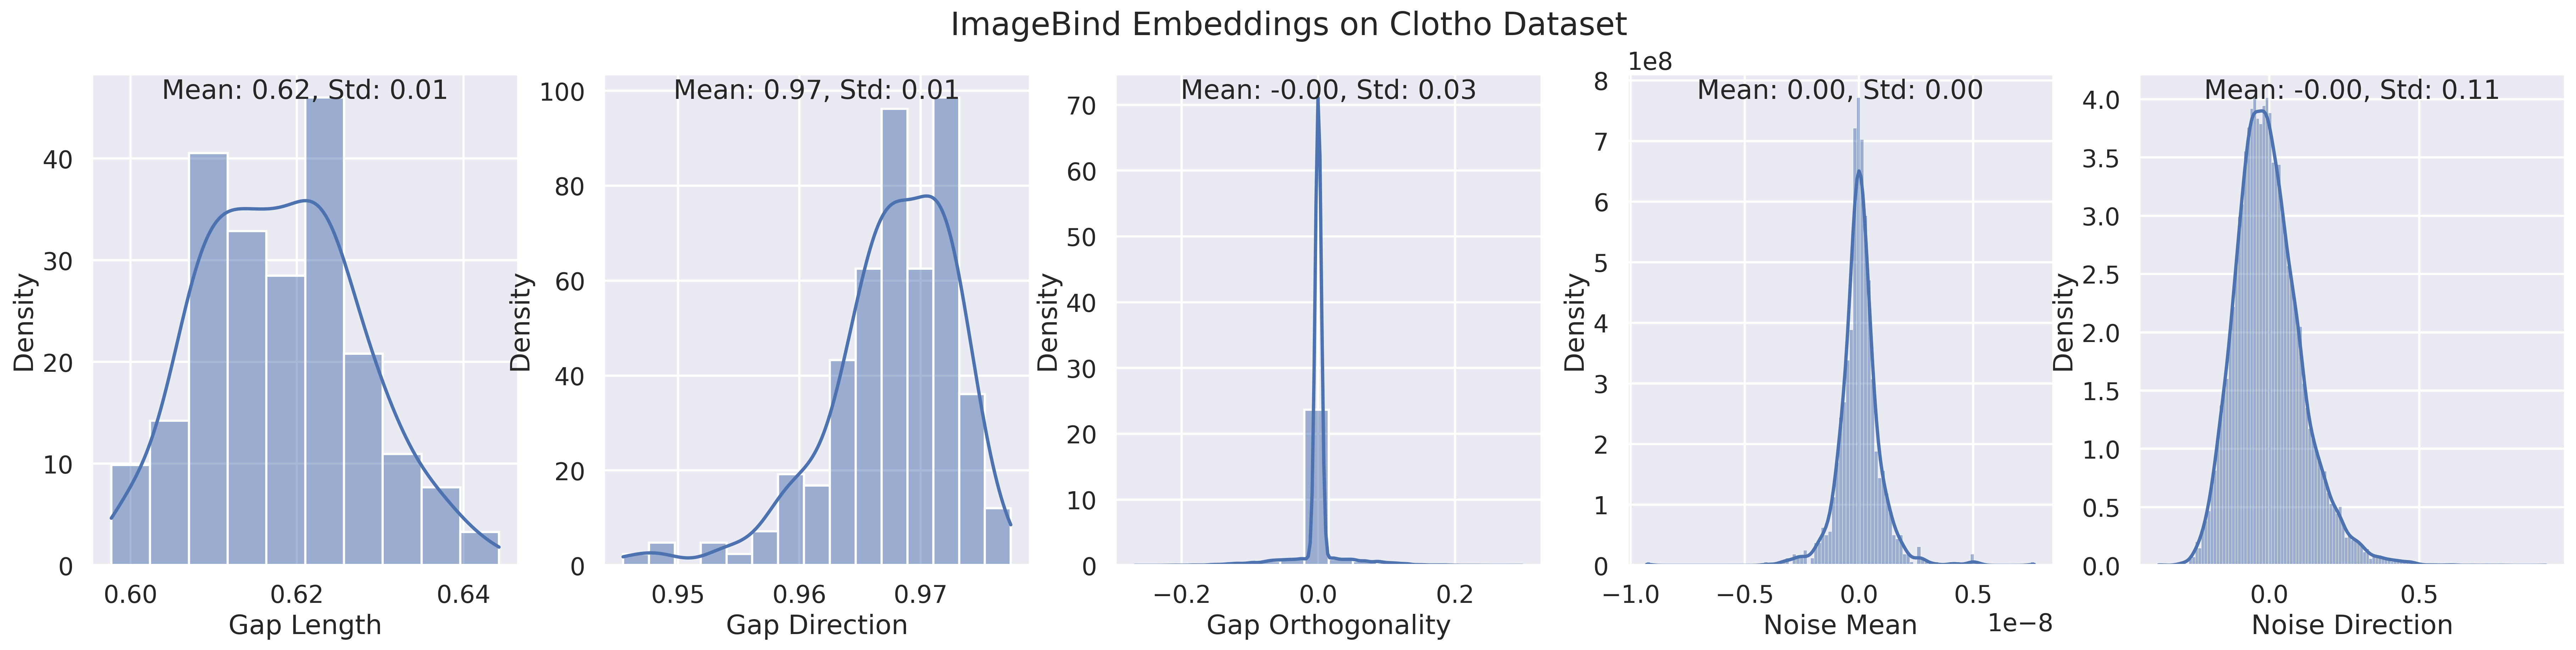

In [5]:
features = pickle.load(open("../data/data_audio_clotho_imagebind.pkl", "rb"))
image_features = torch.tensor([item["x_embed"] for item in features])
text_features = torch.tensor([item["y_embed"] for item in features])
_ = compute_gap_statistics(
    image_features,
    text_features,
    "ImageBind Embeddings on Clotho Dataset",
)

Previous shape: torch.Size([200000, 1024])
New shape: torch.Size([2000, 1024])


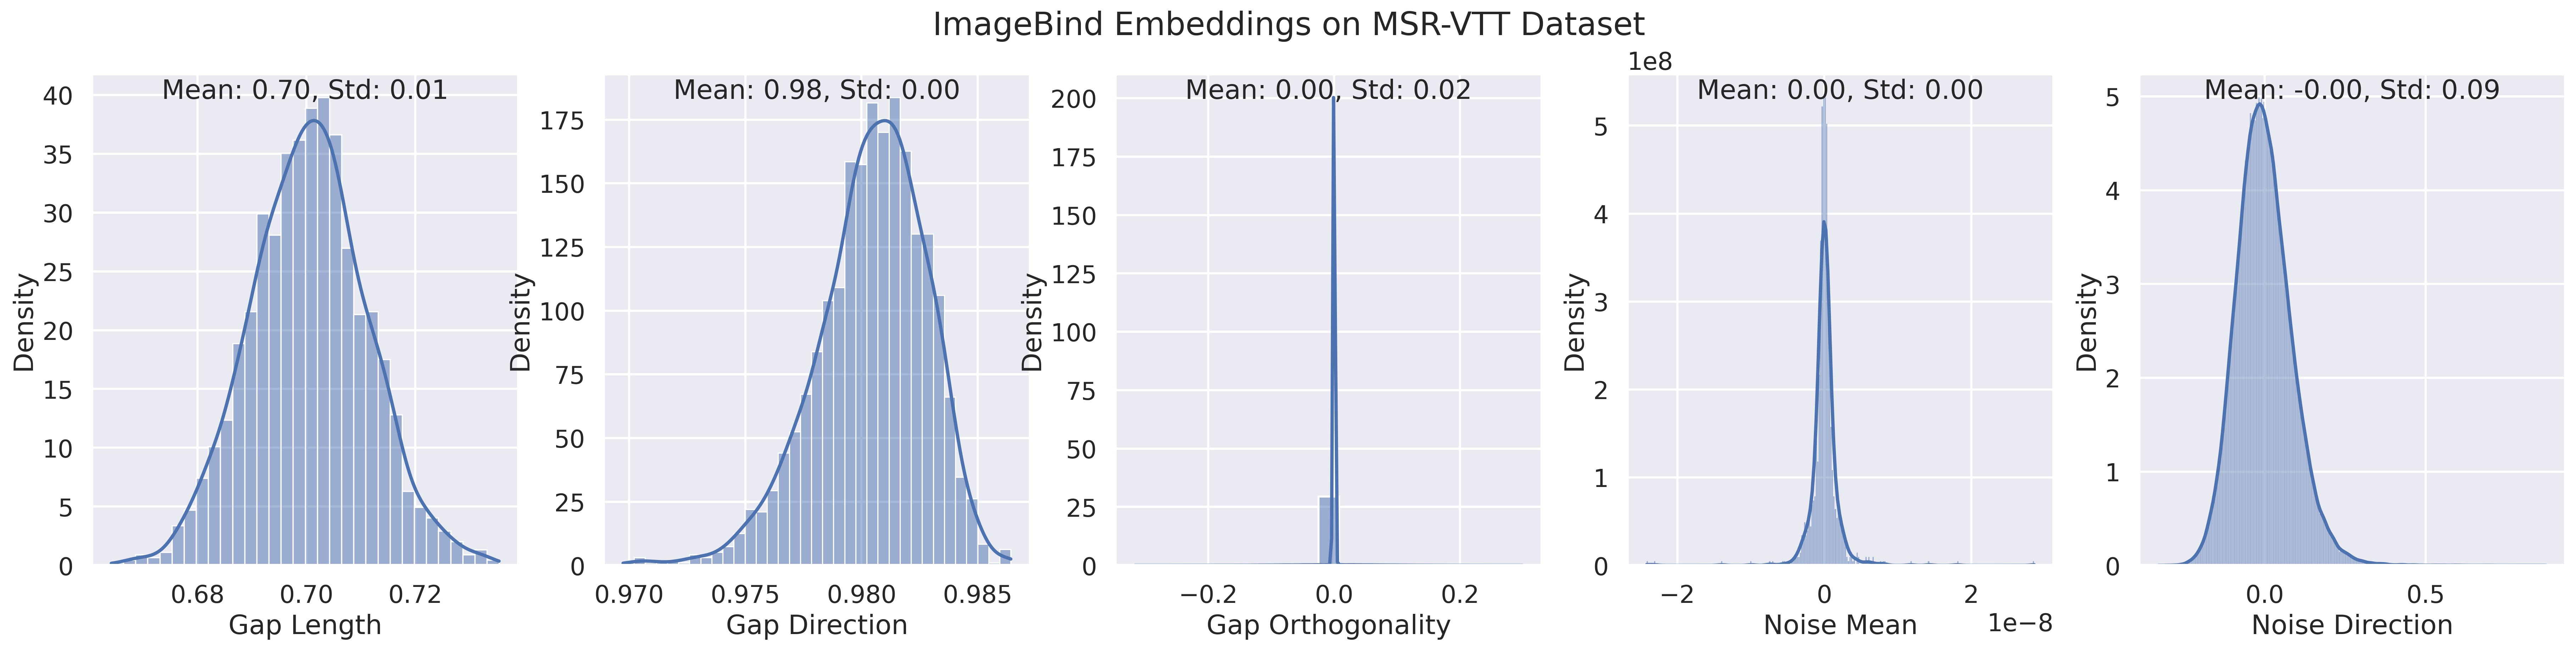

In [6]:
features = pickle.load(open("../data/data_video_msrvtt_imagebind.pkl", "rb"))
image_features = torch.tensor([item["x_embed"] for item in features])
text_features = torch.tensor([item["y_embed"] for item in features])
_ = compute_gap_statistics(
    image_features,
    text_features,
    "ImageBind Embeddings on MSR-VTT Dataset",
)